#II užduotis (Vieno neurono mokymas sprendžiant klasifikavimo uždavinį)

In [138]:

import csv, time, os
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/breast+cancer+wisconsin+original/breast-cancer-wisconsin.data"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [139]:
def load_data(path: str):
    rows = []
    with open(path, "r") as f:
        for r in csv.reader(f):
            if r and len(r) == 11 and "?" not in r[1:10]:
                rows.append(r) # Išsisaugome tik tas eilutes kurios neturi jokių '?'

    X, y = [], []
    for r in rows:
        feats = list(map(float, r[1:10])) # Atmetame ID (pirma stulpeli)
        label = 0 if r[10].strip() == "2" else 1 # Klases keiciame nepiktybinis navikas (2) -> 0, piktybinis (4) -> 1
        X.append(feats) # Sudarome duomenu aibę
        y.append(label) # Sudarome klasių aibę

    X = np.array(X) # Duomenis paverciame i matrica
    y = np.array(y).reshape(-1,1) # Klases paverciam stulpeliu

    idx = np.random.permutation(len(y)) # atsitiktinė eil. tvarka
    X, y = X[idx], y[idx] # pritaikome tą pačią tvarką X ir y

    return X, y

X, y = load_data(path)

In [140]:
# Punktas 2: modelis + mokymas/validavimas/testas (BGD (batch gradient descent) ir SGD (stochastic gradient descent))

# Pagalbinės funkcijos
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))  # sigmoidinė funkcija (nuo 0 iki 1)

def bce_loss(y_true, y_pred, eps=1e-12): # binarinė kryžminė entropija (BCE - Paklaida)
    y_pred = np.clip(y_pred, eps, 1.0 - eps) # apkarpone prognozes į [eps, 1−eps], kad neabūtų log(0) ar log(1)
    return float(-(y_true*np.log(y_pred) + (1.0 - y_true)*np.log(1.0 - y_pred)).mean())

def mse_loss(y_true, y_pred): # vidutinė kvadratinė paklaida (testavimo paklaida)
    return float(((y_true - y_pred) ** 2).mean())

def accuracy(y_true, y_pred): # klasifikavimo tikslumas (0 arba 1)
    y_cls = np.rint(y_pred).astype(int)
    return float((y_cls == y_true).mean())

def split_dataset(X, y, ratios=(0.8, 0.1, 0.1)): # daliname duomenis 80/10/10
    n = len(y);
    a = int(n*ratios[0]);
    b = a + int(n*ratios[1])
    return X[:a], y[:a], X[a:b], y[a:b], X[b:], y[b:]

In [141]:
# Neurono modelis (supaprastintas)
class SigmoidNeuron:
  def __init__(self, input_dim=9, learning_rate=0.002):
      self.lr = learning_rate # mokymosi greitis
      self.w  = np.random.normal(0.0, 0.01, (input_dim,1)) # svoriai (9×1 stulpelis)
      self.b  = 0.0 # poslinkis (bias)

  def forward(self, X):
      return sigmoid(X @ self.w + self.b) # prognozės [0,1] (N×1)

  def train(self, X_train, y_train, X_val, y_val, epochs=120, mode="bgd"):
      hist = {"train_bce": [], "val_bce": [], "train_acc": [], "val_acc": []}  # metrikų istorija
      t0 = time.perf_counter()  # startuojame laiką

      for _ in range(epochs):  # kartojame epochas
          if mode == "sgd":  # SGD: atnaujiname po vieną įrašą
              for i in np.random.permutation(len(X_train)):  # kiekvieną epochą sumaišome eiles
                  x = X_train[i:i+1, :]  # imame eilute
                  y = y_train[i:i+1, :]  # imame eilute
                  y_pred = self.forward(x)  # prognozė
                  delta = y_pred - y  # paklaida
                  self.w -= self.lr * (x.T @ delta)  # atnaujinami svoriai
                  self.b -= self.lr * float(delta.mean())  # atnaujinamas poslinkis
          else:  # BGD: vienas atnaujinimas per epochą
              y_pred = self.forward(X_train)  # prognozės N×1
              delta = y_pred - y_train  # paklaida
              self.w -= self.lr * ((X_train.T @ delta) / len(X_train))  # atnaujinami svoriai (vidurkinam per N)
              self.b -= self.lr * float(delta.mean())  # atnaujinamas poslinkis

          y_tr = self.forward(X_train); y_v = self.forward(X_val)  # prognozės metrikoms
          hist["train_bce"].append(bce_loss(y_train, y_tr))  # mokymo paklaida
          hist["val_bce"].append(bce_loss(y_val, y_v))  # validavimo paklaida
          hist["train_acc"].append(accuracy(y_train, y_tr))  # mokymo tikslumas
          hist["val_acc"].append(accuracy(y_val, y_v))  # validavimo tikslumas

      t1 = time.perf_counter()  # sustabdome laiką
      return hist, (t1 - t0)  # grąžiname metrikas ir mokymo laiką

In [142]:
# Daliname į 80/10/10 (mokymas/validavimas/testavimas)
X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(X, y, ratios=(0.8, 0.1, 0.1))

# Nustatome mokymosi greitį (Learning Rate - LR) ir epochų skaičių
learning_rate = 0.002
epochs = 100

# Kuriame du modelius (su tuo pačiu LR ir epochų skaičiumi): BGD ir SGD
model_bgd = SigmoidNeuron(input_dim=X.shape[1], learning_rate=learning_rate)
model_sgd = SigmoidNeuron(input_dim=X.shape[1], learning_rate=learning_rate)

# Mokome abu modelius ir kaupiame metrikas, fiksuojame mokymo laiką
hist_bgd, time_bgd = model_bgd.train(X_train, y_train, X_val, y_val, epochs=epochs, mode="bgd")  # BGD
hist_sgd, time_sgd = model_sgd.train(X_train, y_train, X_val, y_val, epochs=epochs, mode="sgd")  # SGD

# Testo metrikos abiem atvejams (BCE, MSE, tikslumas)
def eval_test(model, X_t, y_t):
  y_p = model.forward(X_t)
  return bce_loss(y_t, y_p), mse_loss(y_t, y_p), accuracy(y_t, y_p)

bgd_bce, bgd_mse, bgd_acc = eval_test(model_bgd, X_test, y_test)
sgd_bce, sgd_mse, sgd_acc = eval_test(model_sgd, X_test, y_test)

# Išvedamas
print("— PAKETINIS GRADIENTINIS NUSILEIDIMAS (BGD):")
print("Svoriai (9):", np.array2string(model_bgd.w.ravel(), precision=6, separator=", "))
print("Poslinkis (bias):", float(model_bgd.b))
print("Mokymas (paskutinė epocha):  Paklaida=%.6f  Tikslumas=%.4f" % (hist_bgd["train_bce"][-1], hist_bgd["train_acc"][-1])) # [-1] = x[len(x)-1]
print("Validavimas (paskutinė):     Paklaida=%.6f  Tikslumas=%.4f" % (hist_bgd["val_bce"][-1],   hist_bgd["val_acc"][-1]))
print("Testas:                      Paklaida=%.6f  MSE=%.6f  Tikslumas=%.4f" % (bgd_bce, bgd_mse, bgd_acc))
print("Mokymo laikas (s): %.4f" % time_bgd)

print("\n— STOCHASTINIS GRADIENTINIS NUSILEIDIMAS (SGD):")
print("Svoriai (9):", np.array2string(model_sgd.w.ravel(), precision=6, separator=", "))
print("Poslinkis (bias):", float(model_sgd.b))
print("Mokymas (paskutinė epocha):  Paklaida=%.6f  Tikslumas=%.4f" % (hist_sgd["train_bce"][-1], hist_sgd["train_acc"][-1]))
print("Validavimas (paskutinė):     Paklaida=%.6f  Tikslumas=%.4f" % (hist_sgd["val_bce"][-1],   hist_sgd["val_acc"][-1]))
print("Testas:                      Paklaida=%.6f  MSE=%.6f  Tikslumas=%.4f" % (sgd_bce, sgd_mse, sgd_acc))
print("Mokymo laikas (s): %.4f" % time_sgd)

— PAKETINIS GRADIENTINIS NUSILEIDIMAS (BGD):
Svoriai (9): [-0.040173,  0.045737,  0.039156,  0.034218, -0.048678,  0.084838,
 -0.017696,  0.040498, -0.016859]
Poslinkis (bias): -0.04558083036502029
Mokymas (paskutinė epocha):  Paklaida=0.583042  Tikslumas=0.7143
Validavimas (paskutinė):     Paklaida=0.556795  Tikslumas=0.7941
Testas:                      Paklaida=0.582711  MSE=0.198240  Tikslumas=0.7971
Mokymo laikas (s): 0.0210

— STOCHASTINIS GRADIENTINIS NUSILEIDIMAS (SGD):
Svoriai (9): [ 0.126724,  0.21314 ,  0.266856,  0.148896, -0.180512,  0.395351,
  0.049831,  0.151304,  0.089894]
Poslinkis (bias): -4.741074011970024
Mokymas (paskutinė epocha):  Paklaida=0.108554  Tikslumas=0.9707
Validavimas (paskutinė):     Paklaida=0.103407  Tikslumas=0.9706
Testas:                      Paklaida=0.143856  MSE=0.040440  Tikslumas=0.9420
Mokymo laikas (s): 1.1514


Iš pradžių reikia paskaičiuoti TP, TN, FP, FN. Tada galima skaičiuoti tikslumą (_accuracy_), atkūrimą (_recall_), preciziškumą (_precision_), F1.

$Accuracy = \frac{TP + TN}{TP + FP + TN + FN}$ – Parodo, kokia dalis prognozių buvo teisingos.

$Recall = \frac{TP}{TP + FN}$ – Parodo, kiek iš visų teigiamai prognozuotų atvejų buvo tikrai teisingi.

$Precision = \frac{TP}{TP + FP}$ – Parodo, kiek teisingai atpažintų teigiamų atvejų iš visų esamų teigiamų.

$F_1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$ – Harmoninis vidurkis tarp precizijos ir atkūrimo.

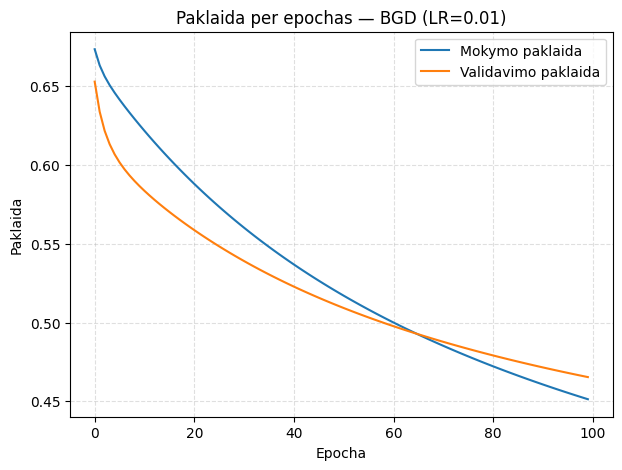

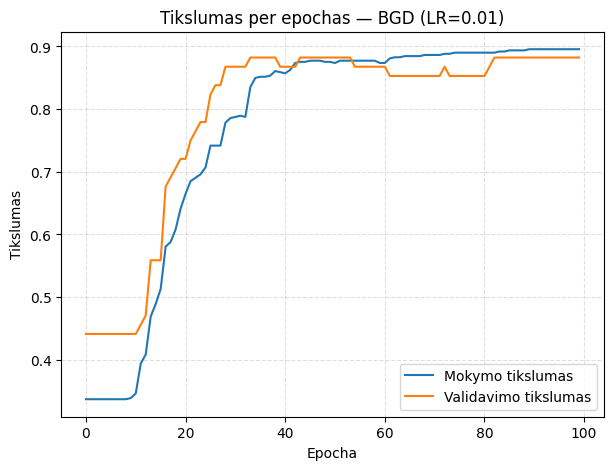

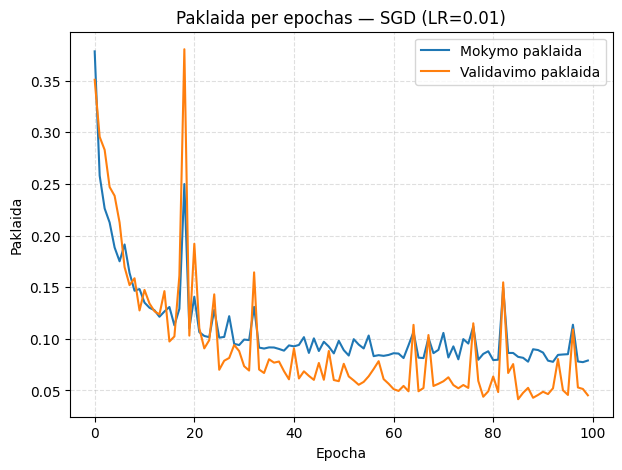

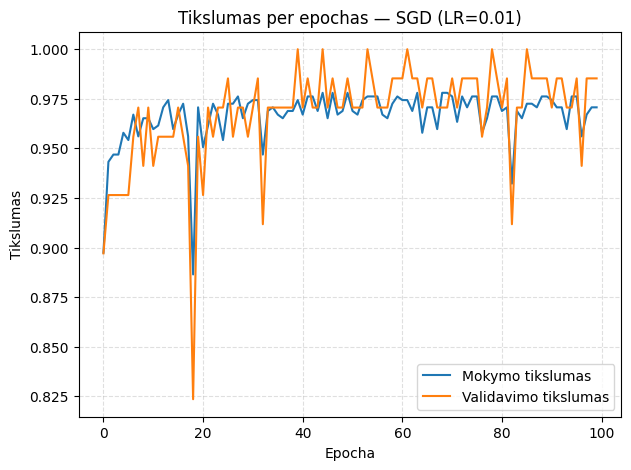

In [143]:
# 3.1: paleidžiame eksperimentus abiem metodams ir keliems LR; saugome rezultatus

def run_one(mode, lr, epochs):  # vienas eksperimentas
    model = SigmoidNeuron(input_dim=X.shape[1], learning_rate=lr)  # modelis
    hist, t = model.train(X_train, y_train, X_val, y_val, epochs=epochs, mode=mode)  # mokymas
    y_test_pred = model.forward(X_test)  # test tikimybės
    return {
        "mode": mode, "lr": lr, "hist": hist, "time": t,                 # istorija + laikas
        "test_bce": bce_loss(y_test, y_test_pred),                       # test paklaida
        "test_acc": accuracy(y_test, y_test_pred),                       # test tikslumas
        "w": model.w.copy(), "b": float(model.b)                         # svoriai ir bias
    }

# pasirenkame bent 3 LR
lrs = [0.001, 0.002, 0.01]  # paprasta trijulė
results = []
for mode in ["bgd", "sgd"]:
    for lr in lrs:
        results.append(run_one(mode, lr, epochs))  # vykdom ekspermentus

# 3.2: geriausias BGD ir geriausias SGD (pagal paskutinės epochos validavimo tikslumą; lygybėje – mažesnė val BCE)

def last_val_acc(r): return r["hist"]["val_acc"][-1] # paskutinės epochos val tikslumas
def last_val_bce(r): return r["hist"]["val_bce"][-1] # paskutinės epochos val paklaida

best_bgd = sorted([r for r in results if r["mode"]=="bgd"],
                  key=lambda r: (-last_val_acc(r), last_val_bce(r)))[0]
best_sgd = sorted([r for r in results if r["mode"]=="sgd"],
                  key=lambda r: (-last_val_acc(r), last_val_bce(r)))[0]

# Braižome BGD
h = best_bgd["hist"]; ttl = f'BGD (LR={best_bgd["lr"]})'
plt.figure(figsize=(7,5))
plt.plot(h["train_bce"], label="Mokymo paklaida")  # mokymo paklaida
plt.plot(h["val_bce"],   label="Validavimo paklaida")  # validavimo paklaida
plt.xlabel("Epocha"); plt.ylabel("Paklaida"); plt.title(f"Paklaida per epochas — {ttl}")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.4); plt.show()

plt.figure(figsize=(7,5))
plt.plot(h["train_acc"], label="Mokymo tikslumas")  # mokymo tikslumas
plt.plot(h["val_acc"],   label="Validavimo tikslumas")  # validavimo tikslumas
plt.xlabel("Epocha"); plt.ylabel("Tikslumas"); plt.title(f"Tikslumas per epochas — {ttl}")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.4); plt.show()

# Braižome SGD
h = best_sgd["hist"]; ttl = f'SGD (LR={best_sgd["lr"]})'
plt.figure(figsize=(7,5))
plt.plot(h["train_bce"], label="Mokymo paklaida")
plt.plot(h["val_bce"],   label="Validavimo paklaida")
plt.xlabel("Epocha"); plt.ylabel("Paklaida"); plt.title(f"Paklaida per epochas — {ttl}")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.4); plt.show()

plt.figure(figsize=(7,5))
plt.plot(h["train_acc"], label="Mokymo tikslumas")
plt.plot(h["val_acc"],   label="Validavimo tikslumas")
plt.xlabel("Epocha"); plt.ylabel("Tikslumas"); plt.title(f"Tikslumas per epochas — {ttl}")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.4); plt.show()

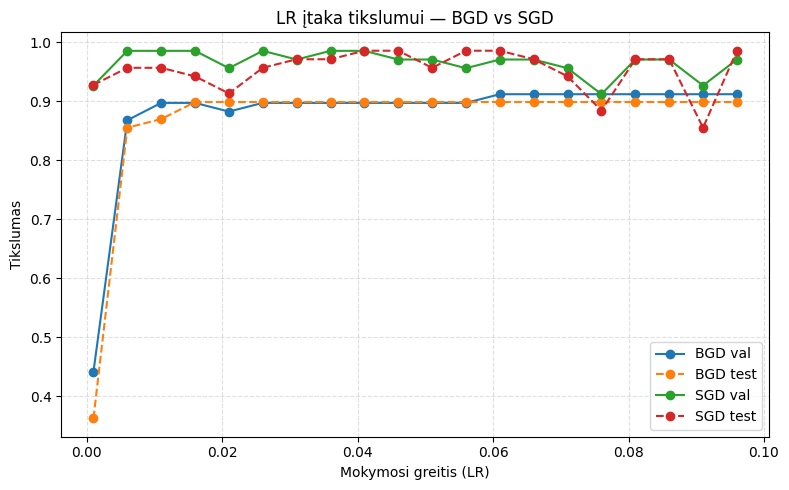

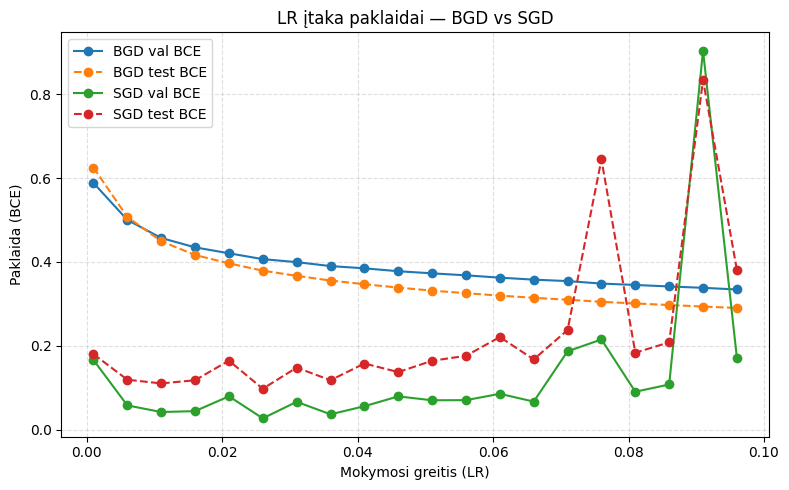

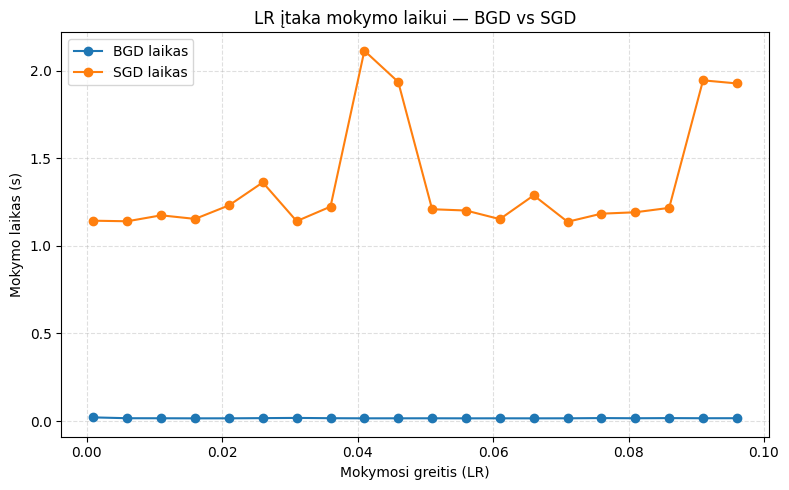

In [144]:
# 3.3: Kombinuotos diagramos (BGD vs SGD) su test reikšmėmis; LR ∈ [0.001..0.1] kas 0.005

# LR sąrašas (linijinis)
lrs = [round(x, 3) for x in np.arange(0.001, 0.101, 0.005)]

# Vykdome bandymus (naudojame jau turimą run_one(...) ir epochs)
res = {m: [run_one(m, lr, epochs) for lr in lrs] for m in ("bgd", "sgd")}  # rezultatai abiem metodams

# Greita pagalbinė serijų rinkėja
def series(mode, key):
    a = res[mode]
    if key == "val_acc":  return [r["hist"]["val_acc"][-1] for r in a]
    if key == "val_bce":  return [r["hist"]["val_bce"][-1] for r in a]
    if key == "test_acc": return [r["test_acc"] for r in a]
    if key == "test_bce": return [r["test_bce"] for r in a]
    if key == "time":     return [r["time"] for r in a]

# 1) LR → tikslumas (validavimas + test)
plt.figure(figsize=(8,5))
plt.plot(lrs, series("bgd","val_acc"),  marker="o", label="BGD val")
plt.plot(lrs, series("bgd","test_acc"), marker="o", linestyle="--", label="BGD test")
plt.plot(lrs, series("sgd","val_acc"),  marker="o", label="SGD val")
plt.plot(lrs, series("sgd","test_acc"), marker="o", linestyle="--", label="SGD test")
plt.xlabel("Mokymosi greitis (LR)"); plt.ylabel("Tikslumas"); plt.title("LR įtaka tikslumui — BGD vs SGD")
plt.grid(True, linestyle="--", alpha=0.4); plt.legend(); plt.tight_layout(); plt.show()

# 2) LR → paklaida (BCE) (validavimas + test)
plt.figure(figsize=(8,5))
plt.plot(lrs, series("bgd","val_bce"),  marker="o", label="BGD val BCE")
plt.plot(lrs, series("bgd","test_bce"), marker="o", linestyle="--", label="BGD test BCE")
plt.plot(lrs, series("sgd","val_bce"),  marker="o", label="SGD val BCE")
plt.plot(lrs, series("sgd","test_bce"), marker="o", linestyle="--", label="SGD test BCE")
plt.xlabel("Mokymosi greitis (LR)"); plt.ylabel("Paklaida (BCE)"); plt.title("LR įtaka paklaidai — BGD vs SGD")
plt.grid(True, linestyle="--", alpha=0.4); plt.legend(); plt.tight_layout(); plt.show()

# 3) LR → mokymo laikas
plt.figure(figsize=(8,5))
plt.plot(lrs, series("bgd","time"), marker="o", label="BGD laikas")
plt.plot(lrs, series("sgd","time"), marker="o", label="SGD laikas")
plt.xlabel("Mokymosi greitis (LR)"); plt.ylabel("Mokymo laikas (s)"); plt.title("LR įtaka mokymo laikui — BGD vs SGD")
plt.grid(True, linestyle="--", alpha=0.4); plt.legend(); plt.tight_layout(); plt.show()

In [145]:
# 3.4: santraukos lentelė (metodas × LR) su validavimo ir testo rodikliais + laikas

def row(r):
    return (f'{r["mode"].upper()}  LR={r["lr"]}:  '
            f'ValAcc={last_val_acc(r):.4f}  ValBCE={last_val_bce(r):.6f}  '
            f'TestAcc={r["test_acc"]:.4f}  TestBCE={r["test_bce"]:.6f}  '
            f'Time={r["time"]:.3f}s')

for r in sorted(results, key=lambda x: (x["mode"], x["lr"])):
    print(row(r))

print("\n— Geriausi variantai —")
print("BGD:", row(best_bgd))
print("SGD:", row(best_sgd))

BGD  LR=0.001:  ValAcc=0.5147  ValBCE=0.576873  TestAcc=0.4928  TestBCE=0.613320  Time=0.016s
BGD  LR=0.002:  ValAcc=0.7206  ValBCE=0.560292  TestAcc=0.7101  TestBCE=0.593032  Time=0.016s
BGD  LR=0.01:  ValAcc=0.8824  ValBCE=0.465383  TestAcc=0.8551  TestBCE=0.461561  Time=0.015s
SGD  LR=0.001:  ValAcc=0.9559  ValBCE=0.149820  TestAcc=0.9275  TestBCE=0.168064  Time=1.148s
SGD  LR=0.002:  ValAcc=0.9559  ValBCE=0.098825  TestAcc=0.9565  TestBCE=0.138288  Time=1.768s
SGD  LR=0.01:  ValAcc=0.9853  ValBCE=0.045307  TestAcc=0.9565  TestBCE=0.113485  Time=1.902s

— Geriausi variantai —
BGD: BGD  LR=0.01:  ValAcc=0.8824  ValBCE=0.465383  TestAcc=0.8551  TestBCE=0.461561  Time=0.015s
SGD: SGD  LR=0.01:  ValAcc=0.9853  ValBCE=0.045307  TestAcc=0.9565  TestBCE=0.113485  Time=1.902s


In [146]:
print("\nBGD: mokymo ir validavimo Paklaida per epochas")
for i, (tr, va) in enumerate(zip(hist_bgd["train_bce"], hist_bgd["val_bce"]), 1):
    print(f"Epocha {i:3d}: Train={tr:.6f}  Val={va:.6f}")

print("\nSGD: mokymo ir validavimo Paklaida per epochas")
for i, (tr, va) in enumerate(zip(hist_sgd["train_bce"], hist_sgd["val_bce"]), 1):
    print(f"Epocha {i:3d}: Train={tr:.6f}  Val={va:.6f}")


BGD: mokymo ir validavimo Paklaida per epochas
Epocha   1: Train=0.688117  Val=0.701603
Epocha   2: Train=0.682911  Val=0.691993
Epocha   3: Train=0.678280  Val=0.683374
Epocha   4: Train=0.674148  Val=0.675630
Epocha   5: Train=0.670450  Val=0.668656
Epocha   6: Train=0.667127  Val=0.662362
Epocha   7: Train=0.664130  Val=0.656666
Epocha   8: Train=0.661416  Val=0.651500
Epocha   9: Train=0.658947  Val=0.646800
Epocha  10: Train=0.656691  Val=0.642514
Epocha  11: Train=0.654620  Val=0.638593
Epocha  12: Train=0.652709  Val=0.634997
Epocha  13: Train=0.650939  Val=0.631690
Epocha  14: Train=0.649290  Val=0.628639
Epocha  15: Train=0.647747  Val=0.625817
Epocha  16: Train=0.646298  Val=0.623200
Epocha  17: Train=0.644929  Val=0.620767
Epocha  18: Train=0.643632  Val=0.618497
Epocha  19: Train=0.642397  Val=0.616376
Epocha  20: Train=0.641217  Val=0.614387
Epocha  21: Train=0.640086  Val=0.612518
Epocha  22: Train=0.638997  Val=0.610758
Epocha  23: Train=0.637945  Val=0.609096
Epocha  2